In [719]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import timedelta
import scipy.stats as st
from datetime import datetime
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import time
import folium
from folium import Choropleth ,  Circle, Marker
import gpxpy
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as sts 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [720]:
zone = pd.read_csv('zone.csv').drop(['Unnamed: 0'],axis=1)

In [721]:
df_2022_06 = pd.read_parquet('yellow_tripdata_2022-06.parquet')

In [722]:
def merge_data(df):
    temp_df = zone.copy()
    temp_df.rename(columns = {'LocationID':"PULocationID"},inplace=True )
    df = df.merge(temp_df,on='PULocationID')
    df.rename(columns = {'latitude':"PUlatitude", 'longitude':"PUlongitude"},inplace=True )
    temp_df2 = zone.copy()
    temp_df2.rename(columns = {'LocationID':"DOLocationID"},inplace=True )
    df = df.merge(temp_df2,on='DOLocationID')
    df.rename(columns = {'latitude':"DOlatitude", 'longitude':"DOlongitude"},inplace=True )
    df['time_taken'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['time_taken'] = [timedelta.Timedelta(x).total.seconds for x in df['time_taken']]
    df['time_taken'] = round((df['time_taken']/60),2)
    df['speed(miles/hours)'] =round((df['trip_distance'])/(df['time_taken']/60),2)
    return df[['tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance','time_taken', 'speed(miles/hours)','store_and_fwd_flag','PUlatitude', 'PUlongitude', 'DOlatitude', 'DOlongitude',
        'payment_type', 'fare_amount', 'extra','mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge','total_amount', 'congestion_surcharge', 'airport_fee']]



In [723]:
def na_value(data):
    return round(((data.isna().sum()[data.isna().sum()>0])/len(data))*100,2)

In [724]:
na_value(df_2022_06)

passenger_count         3.72
RatecodeID              3.72
store_and_fwd_flag      3.72
congestion_surcharge    3.72
airport_fee             3.72
dtype: float64

In [725]:
def drop_na(df):
    return df.dropna(axis=0, inplace=True)

In [726]:
drop_na(df_2022_06)

## Pickup time and Dropoff Time

In [727]:
df_2022_06 = df_2022_06[(df_2022_06['tpep_pickup_datetime'] > '2022-06-01 00:00:00') & (df_2022_06['tpep_pickup_datetime'] < '2022-06-30 23:59:59')]

## Passenger

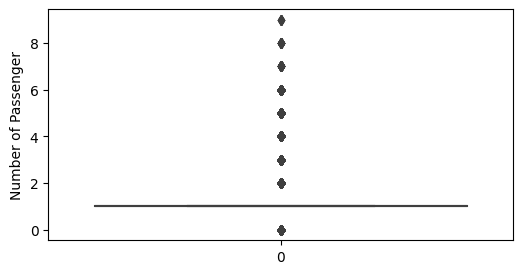

In [728]:
plt.figure(figsize = (6,3))
sns.boxplot(df_2022_06["passenger_count"], orient = "v")
plt.tick_params(labelsize = 10)
plt.ylabel("Number of Passenger", fontsize = 10)
plt.show()

In [729]:
def outlier_passenger(df,Number_of_passenger):
    x = len(df[df['passenger_count'] == Number_of_passenger])
    per_outlier = (x/df.shape[0])*100
    print('Number of outlier data is {} and in percentage is {} %'.format((x),round(per_outlier,2)))

In [730]:
outlier_passenger(df_2022_06,3)

Number of outlier data is 141320 and in percentage is 4.13 %


In [731]:
def outliers(df):
    return df[(df['passenger_count']<=3) | df['passenger_count'] > 0]

In [732]:
df_2022_06 = outliers(df_2022_06)

## Trip distance

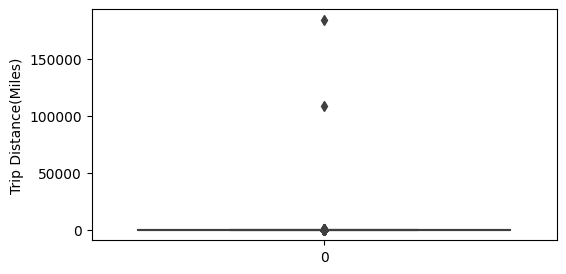

In [733]:
plt.figure(figsize = (6,3))
sns.boxplot(df_2022_06["trip_distance"], orient = "v")
plt.tick_params(labelsize = 10)
plt.ylabel("Trip Distance(Miles)", fontsize = 10)
plt.show()

In [734]:
for j in range(91,100,1):
    print("{} perncetile is ".format(j),np.percentile(df_2022_06['trip_distance'],j))
print("{} perncetile is ".format(100),np.percentile(df_2022_06['trip_distance'],100))

91 perncetile is  9.76
92 perncetile is  10.5
93 perncetile is  11.4
94 perncetile is  12.78
95 perncetile is  15.54
96 perncetile is  17.1
97 perncetile is  17.9
98 perncetile is  18.69
99 perncetile is  20.24
100 perncetile is  184340.8


In [735]:
for j in np.arange(0.0,1.0,0.1):
    print("{} perncetile is ".format(float(99+j)),np.percentile(df_2022_06['trip_distance'],float(99+j)))
print("{} perncetile is ".format(100),np.percentile(df_2022_06['trip_distance'],100))

99.0 perncetile is  20.24
99.1 perncetile is  20.5
99.2 perncetile is  20.76
99.3 perncetile is  21.05
99.4 perncetile is  21.4
99.5 perncetile is  21.8
99.6 perncetile is  22.43
99.7 perncetile is  23.67
99.8 perncetile is  26.3
99.9 perncetile is  30.438380000004546
100 perncetile is  184340.8


In [736]:
def fix_distance(df):
    return df[df['trip_distance']<30]

In [737]:
df_2022_06 = fix_distance(df_2022_06)

## Time_taken

In [738]:
df_2022_06 = merge_data(df_2022_06)

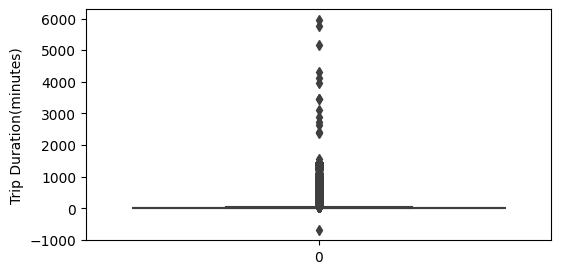

In [739]:
plt.figure(figsize = (6,3))
sns.boxplot(df_2022_06["time_taken"], orient = "v")
plt.tick_params(labelsize = 10)
plt.ylabel("Trip Duration(minutes)", fontsize = 10)
plt.show()

In [740]:
def fix_time_taken(df):
    return df[(df.time_taken>1) & (df.time_taken<720)]

In [741]:
df_2022_06 = fix_time_taken(df_2022_06)

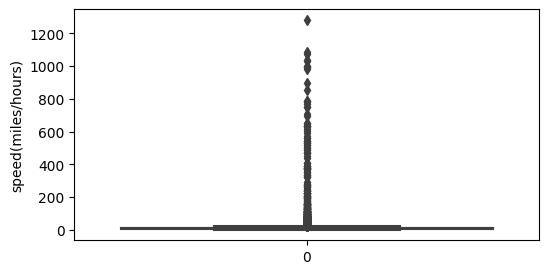

In [742]:
plt.figure(figsize = (6,3))
sns.boxplot(df_2022_06['speed(miles/hours)'], orient = "v")
plt.tick_params(labelsize = 10)
plt.ylabel("speed(miles/hours)", fontsize = 10)
plt.show()

In [743]:
for j in range(0,10,1):
    print("{} perncetile is ".format(j),np.percentile(df_2022_06['speed(miles/hours)'],j))
print("{} perncetile is ".format(100),np.percentile(df_2022_06['speed(miles/hours)'],100))

0 perncetile is  0.0
1 perncetile is  2.88
2 perncetile is  3.75
3 perncetile is  4.23
4 perncetile is  4.58
5 perncetile is  4.87
6 perncetile is  5.12
7 perncetile is  5.34
8 perncetile is  5.53
9 perncetile is  5.71
100 perncetile is  1283.61


In [744]:
for j in range(0,100,10):
    print("{} perncetile is ".format(j),np.percentile(df_2022_06['speed(miles/hours)'],j))
print("{} perncetile is ".format(100),np.percentile(df_2022_06['speed(miles/hours)'],100))

0 perncetile is  0.0
10 perncetile is  5.88
20 perncetile is  7.17
30 perncetile is  8.2
40 perncetile is  9.17
50 perncetile is  10.19
60 perncetile is  11.38
70 perncetile is  12.9
80 perncetile is  15.23
90 perncetile is  19.78
100 perncetile is  1283.61


In [745]:
for j in range(91,100,1):
    print("{} perncetile is ".format(j),np.percentile(df_2022_06['speed(miles/hours)'],j))
print("{} perncetile is ".format(100),np.percentile(df_2022_06['speed(miles/hours)'],100))

91 perncetile is  20.5
92 perncetile is  21.32
93 perncetile is  22.24
94 perncetile is  23.29
95 perncetile is  24.52
96 perncetile is  25.99
97 perncetile is  27.88
98 perncetile is  30.43
99 perncetile is  34.4
100 perncetile is  1283.61


In [746]:
for j in np.arange(0.0,1.0,0.1):
    print("{} perncetile is ".format(float(99+j)),np.percentile(df_2022_06['speed(miles/hours)'],float(99+j)))
print("{} perncetile is ".format(100),np.percentile(df_2022_06['speed(miles/hours)'],100))

99.0 perncetile is  34.4
99.1 perncetile is  34.97
99.2 perncetile is  35.59
99.3 perncetile is  36.28
99.4 perncetile is  37.07
99.5 perncetile is  37.96
99.6 perncetile is  39.05
99.7 perncetile is  40.39
99.8 perncetile is  42.19
99.9 perncetile is  45.08
100 perncetile is  1283.61


In [747]:
def fix_speed(df):
    return df[(df['speed(miles/hours)']>0) & (df['speed(miles/hours)']<45)]

In [748]:
df_2022_06 = fix_speed(df_2022_06)

## Total Amount

<function matplotlib.pyplot.show(close=None, block=None)>

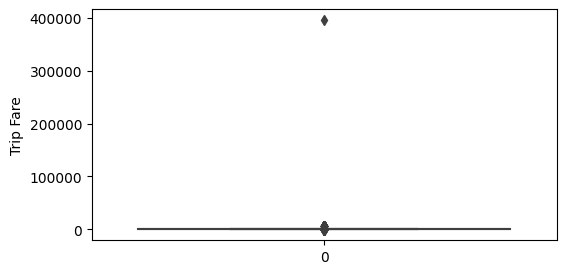

In [749]:
plt.figure(figsize = (6,3))
ax = sns.boxplot(df_2022_06["total_amount"], orient = "v")
plt.tick_params(labelsize = 10)
plt.ylabel("Trip Fare", fontsize = 10)
plt.show

In [750]:
for j in range(0,100,10):
    print("{} perncetile is ".format(j),np.percentile(df_2022_06['total_amount'],j))
print("{} perncetile is ".format(100),np.percentile(df_2022_06['total_amount'],100))

0 perncetile is  -663.55
10 perncetile is  9.96
20 perncetile is  11.76
30 perncetile is  12.96
40 perncetile is  14.3
50 perncetile is  15.96
60 perncetile is  17.8
70 perncetile is  20.76
80 perncetile is  25.56
90 perncetile is  41.55
100 perncetile is  395848.24


In [751]:
for j in np.arange(0.0,1.0,0.1):
    print("{} perncetile is ".format(float(99+j)),np.percentile(df_2022_06['total_amount'],float(99+j)))
print("{} perncetile is ".format(100),np.percentile(df_2022_06['total_amount'],100))

99.0 perncetile is  78.88
99.1 perncetile is  79.62
99.2 perncetile is  80.87
99.3 perncetile is  81.12
99.4 perncetile is  82.03
99.5 perncetile is  84.5
99.6 perncetile is  88.55
99.7 perncetile is  95.15
99.8 perncetile is  103.25
99.9 perncetile is  116.55
100 perncetile is  395848.24


In [752]:
def fix_fare(df):
    return df[(df['total_amount']>0) & (df['total_amount']<100)]

In [753]:
df_2022_06 = fix_fare(df_2022_06)

In [754]:
df_2022_06

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,time_taken,speed(miles/hours),store_and_fwd_flag,PUlatitude,PUlongitude,DOlatitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2022-06-01 00:25:41,2022-06-01 00:48:22,1.0,11.00,22.68,29.10,N,40.76439,-73.87402,-28.63161,...,1,32.0,3.0,0.5,2.00,6.55,0.3,44.35,2.5,0.00
1,2022-06-01 00:10:17,2022-06-01 00:34:46,1.0,12.40,24.48,30.39,N,40.76439,-73.87402,-28.63161,...,1,36.0,3.0,0.5,9.00,6.55,0.3,55.35,2.5,0.00
2,2022-06-01 09:18:54,2022-06-01 09:59:52,1.0,10.62,40.97,15.55,N,40.76439,-73.87402,-28.63161,...,1,34.5,0.0,0.5,5.65,6.55,0.3,50.00,2.5,0.00
3,2022-06-01 10:57:55,2022-06-01 12:01:37,1.0,12.06,63.70,11.36,N,40.76439,-73.87402,-28.63161,...,2,47.0,0.0,0.5,0.00,6.55,0.3,56.85,2.5,0.00
4,2022-06-01 12:10:46,2022-06-01 12:52:32,1.0,10.97,41.77,15.76,N,40.76439,-73.87402,-28.63161,...,1,37.0,0.0,0.5,9.37,6.55,0.3,56.22,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421539,2022-06-03 18:19:32,2022-06-03 19:57:32,1.0,28.77,98.00,17.61,N,40.77572,-73.87453,40.52196,...,2,87.0,0.5,0.5,0.00,6.55,0.3,98.60,2.5,1.25
3421540,2022-06-07 00:18:11,2022-06-07 01:01:16,1.0,29.99,43.08,41.77,N,40.77572,-73.87453,40.52196,...,2,79.0,0.5,0.5,0.00,13.10,0.3,94.65,0.0,1.25
3421542,2022-06-26 07:20:53,2022-06-26 08:04:39,1.0,27.60,43.77,37.83,N,40.74213,-73.97781,40.52196,...,2,75.0,2.5,0.5,0.00,6.55,0.3,84.85,2.5,0.00
3421544,2022-06-25 23:38:48,2022-06-26 00:34:33,1.0,20.50,55.75,22.06,N,33.76790,-118.19940,40.52196,...,1,59.0,3.0,0.5,3.00,13.10,0.3,78.90,2.5,0.00


In [755]:
outside_NYC = df_2022_06[((df_2022_06.PUlatitude <= 40.5774) | (df_2022_06.PUlongitude <= -74.15) | (df_2022_06.PUlatitude >= 40.9176) | (df_2022_06.PUlongitude >= -73.7004))]

In [756]:
# locations = outside_NYC[['PUlatitude', 'PUlongitude']][:10000]
# locationlist = locations.values.tolist()
# map = folium.Map(location=[40.73,-73.93], zoom_start=12)
# for point in range(0, len(locationlist)):
#     folium.Marker(locationlist[point]).add_to(map)
# map

In [757]:
#Deleting pickups / dropoff out of NYC
new_data_2022_06 = df_2022_06[(((df_2022_06.PUlatitude >= 40.5774) & (df_2022_06.PUlatitude <= 40.9176)) & ((df_2022_06.PUlongitude >= -74.15) & (df_2022_06.PUlongitude <= -73.7004)))]
new_data_2022_06 = df_2022_06[(((df_2022_06.DOlatitude >= 40.5774) & (df_2022_06.DOlatitude <= 40.9176)) & ((df_2022_06.DOlongitude >= -74.15) & (df_2022_06.DOlongitude <= -73.7004)))]

## Clustering Data

In [758]:
coord = new_data_2022_06[["PUlatitude", "PUlongitude"]].values

In [759]:
neighbours=[]
def find_min_distance(cluster_centers, cluster_len):
    nice_point = 0
    bad_point = 0
    less = []
    more = []
    min_dist = 1000
    for i in range(0,cluster_len):
        nice_point = 0
        bad_point = 0
        for j in range(0,cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <=2:
                    nice_point+=1
                else:
                    bad_point+=1
        less.append(nice_point)
        more.append(bad_point)
    neighbours.append(less)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less)/len(less)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more)/len(more)),"\nMin inter-cluster distance = ",min_dist,"\n---")
def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000, random_state=42).fit(coord)
    new_data_2022_06['pickup_cluster'] = kmeans.predict(new_data_2022_06[['PUlatitude', 'PUlongitude']])
    cluster_centre = kmeans.cluster_centers_
    cluster_len = len(cluster_centre)
    return cluster_centre, cluster_len
for increment in range(10, 100, 10):
    cluster_centre, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centre, cluster_len)     

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 0.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 9.0 
Min inter-cluster distance =  266.35291252773976 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 0.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 19.0 
Min inter-cluster distance =  5.724806827661376 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 0.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 29.0 
Min inter-cluster distance =  2.3083709631279694 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 1.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 39.0 
Min inter-cluster distance =

### Elbow Method:
#### The method plots the relationship between the number of clusters and the within-cluster sum of squared distances (WCSS) from the centroid of each cluster to its constituent points

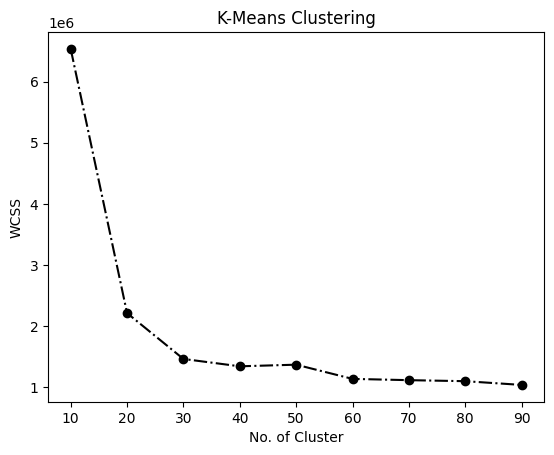

In [760]:
wcss = []
for i in range(10,100,10):
    kmeans = MiniBatchKMeans(n_clusters=i, batch_size=10000, random_state=42)
    kmeans.fit(coord)
    wcss.append(kmeans.inertia_)
plt.plot(range(10,100,10), wcss, marker = 'o', linestyle='-.',color='black')
plt.xlabel("No. of Cluster")
plt.ylabel("WCSS")
plt.title("K-Means Clustering")
plt.show()

### Calinski-Harabasz Index:
#### The CH Index measures the ratio of the between-cluster variance to the within-cluster variance. A higher CH Index score indicates a better clustering solution. The value of the CH Index ranges from 0 to positive infinity. A value close to 0 indicates poor clustering, while a value close to positive infinity indicates a good clustering solution.

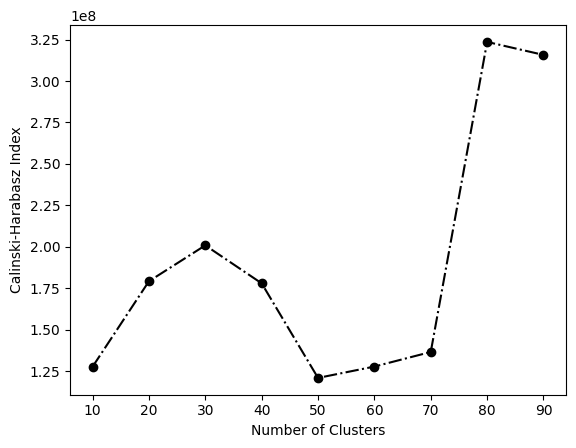

In [761]:
# Initialize empty list to store CH Index scores
ch_index_scores = []

# Fit k-means models with different number of clusters
for k in range(10,100,10):
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=10000, random_state=42)
    kmeans.fit(coord)
    ch_index = calinski_harabasz_score(coord, kmeans.labels_)
    ch_index_scores.append(ch_index)

# Plot the CH Index scores
plt.plot(range(10,100,10), ch_index_scores, marker='o', linestyle='-.',color='black')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.show()


### Davies_bouldin_score:
#### the average similarity between each cluster and its most similar cluster, with similarity measured as the distance between cluster centroids and the average distance from samples in one cluster to the centroid of the most similar cluster.
#### ~ In general, a lower Davies-Bouldin Index value indicates a better clustering solution, as it suggests that the clusters are more separated and less similar to each other.

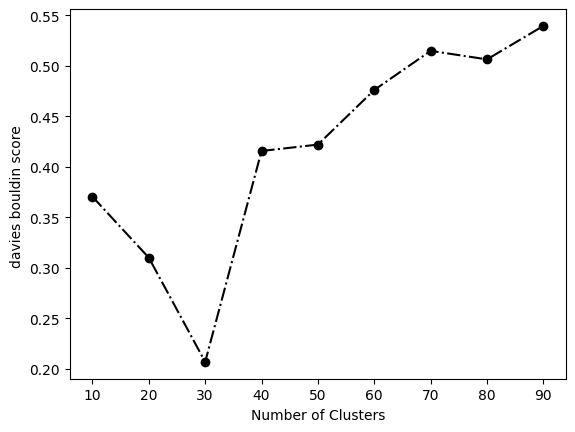

In [762]:
# Initialize empty list to store CH Index scores
davies_bouldin_scores = []

# Fit k-means models with different number of clusters
for k in range(10,100,10):
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=10000, random_state=42)
    kmeans.fit(coord)
    db_index = davies_bouldin_score(coord, kmeans.labels_)
    davies_bouldin_scores.append(db_index)

# Plot the CH Index scores
plt.plot(range(10,100,10), davies_bouldin_scores, marker='o', linestyle='-.',color='black')
plt.xlabel('Number of Clusters')
plt.ylabel('davies bouldin score ')
plt.show()

### Silhouette Coefficient:
#### The Silhouette Coefficient is a value between -1 and 1 that represents the similarity of a data point to its own cluster compared to other clusters. A value of 1 indicates that the data point is well-separated from other clusters and a value of -1 indicates that the data point is more similar to a different cluster than its own.

In [764]:
# plt.figure(figsize = (10,6))

# from sklearn.metrics import silhouette_samples, silhouette_score
# # Initialize empty list to store CH Index scores
# silhoutte = []

# # Fit k-means models with different number of clusters
# for k in range(10,100,10):
#     kmeans = MiniBatchKMeans(n_clusters=k, batch_size=10000, random_state=42)
#     kmeans.fit(coord)
#     si_index = silhouette_score(coord, kmeans.labels_)
#     silhoutte.append(si_index)
# plt.subplot(1,2,1)
# plt.hist(silhoutte, bins=100)
# plt.xlabel('Silhouette Coefficient')
# plt.ylabel('Count')
# plt.title('Distribution of Silhouette Coefficient Values')
# plt.subplot(1,2,2)
# plt.plot(range(10,100,10), silhoutte, marker='o', linestyle='-.',color='black')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette score ')
# plt.show()



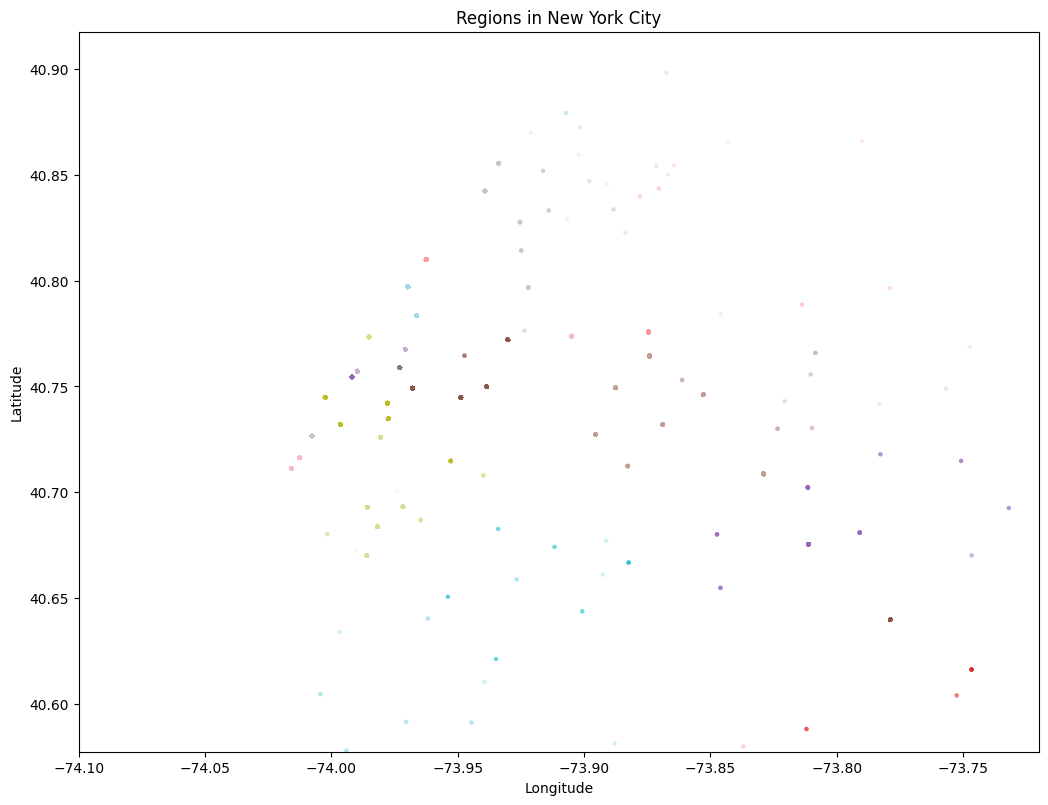

In [765]:
#Plotting NYC Regions
NYC_latitude_range = (40.5774, 40.9176)
NYC_Longitude_range = (-74.15, -73.7004)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(new_data_2022_06.PUlongitude.values[:100000], new_data_2022_06.PUlatitude.values[:100000], s=10, lw=0,
               c=new_data_2022_06.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
ax.set_xlim(-74.10, -73.72)
ax.set_ylim(40.5774, 40.9176)
ax.set_title("Regions in New York City")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

In [766]:
# locations = new_data_2021_06[['PUlatitude', 'PUlongitude']][:10000]
# locationlist = locations.values.tolist()
# map = folium.Map(location=[40.73,-73.93], zoom_start=12)
# for point in range(0, len(locationlist)):
#     folium.Marker(locationlist[point]).add_to(map)
# map

# Cleaning Data For Rest months and saving clusters

In [767]:
df_2022_07 = pd.read_parquet('yellow_tripdata_2022-07.parquet')
df_2022_08 = pd.read_parquet('yellow_tripdata_2022-08.parquet')
df_2022_09 = pd.read_parquet('yellow_tripdata_2022-09.parquet')
df_2022_10 = pd.read_parquet('yellow_tripdata_2022-10.parquet')
df_2022_11 = pd.read_parquet('yellow_tripdata_2022-11.parquet')

In [311]:
df_2022_07 = df_2022_07[(df_2022_07['tpep_pickup_datetime'] > '2022-07-01 00:00:00') & (df_2022_07['tpep_pickup_datetime'] < '2022-07-30 23:59:59')]

In [312]:
df_2022_08 = df_2022_08[(df_2022_08['tpep_pickup_datetime'] > '2022-08-01 00:00:00') & (df_2022_08['tpep_pickup_datetime'] < '2022-08-31 23:59:59')]

In [313]:
df_2022_09 = df_2022_09[(df_2022_09['tpep_pickup_datetime'] > '2022-09-01 00:00:00') & (df_2022_09['tpep_pickup_datetime'] < '2022-09-30 23:59:59')]

In [314]:
df_2022_10 = df_2022_10[(df_2022_10['tpep_pickup_datetime'] > '2022-10-01 00:00:00') & (df_2022_10['tpep_pickup_datetime'] < '2022-10-31 23:59:59')]

In [315]:
df_2022_11 = df_2022_11[(df_2022_11['tpep_pickup_datetime'] > '2022-11-01 00:00:00') & (df_2022_11['tpep_pickup_datetime'] < '2022-11-30 23:59:59')]

In [316]:
df_2022_07  = merge_data(df_2022_07) 

In [317]:
df_2022_08  = merge_data(df_2022_08) 

In [318]:
df_2022_09  = merge_data(df_2022_09) 

In [319]:
df_2022_10  = merge_data(df_2022_10) 

In [320]:
df_2022_11  = merge_data(df_2022_11)

In [321]:
drop_na(df_2022_07) 
drop_na(df_2022_08) 
drop_na(df_2022_09) 
drop_na(df_2022_10) 
drop_na(df_2022_11)

In [322]:
df_2022_07 = outliers(df_2022_07)
df_2022_08 = outliers(df_2022_08)
df_2022_09 = outliers(df_2022_09)
df_2022_10 = outliers(df_2022_10)
df_2022_11 = outliers(df_2022_11)

In [323]:
df_2022_07 = fix_distance(df_2022_07)
df_2022_08 = fix_distance(df_2022_08)
df_2022_09 = fix_distance(df_2022_09)
df_2022_10 = fix_distance(df_2022_10)
df_2022_11 = fix_distance(df_2022_11)

In [324]:
df_2022_07 = fix_fare(df_2022_07)
df_2022_08 = fix_fare(df_2022_08)
df_2022_09 = fix_fare(df_2022_09)
df_2022_10 = fix_fare(df_2022_10)
df_2022_11 = fix_fare(df_2022_11)

In [325]:
df_2022_07 = fix_speed(df_2022_07)
df_2022_08 = fix_speed(df_2022_08)
df_2022_09 = fix_speed(df_2022_09)
df_2022_10 = fix_speed(df_2022_10)
df_2022_11 = fix_speed(df_2022_11)

In [326]:
df_2022_07 = fix_time_taken(df_2022_07)
df_2022_08 = fix_time_taken(df_2022_08)
df_2022_09 = fix_time_taken(df_2022_09)
df_2022_10 = fix_time_taken(df_2022_10)
df_2022_11 = fix_time_taken(df_2022_11)

In [327]:
def fix_lat_long(df):
    df = df[(((df.PUlatitude >= 40.5774) & (df.PUlatitude <= 40.9176)) & ((df.PUlongitude >= -74.15) & (df.PUlongitude <= -73.7004)))]
    df = df[(((df.DOlatitude >= 40.5774) & (df.DOlatitude <= 40.9176)) & ((df.DOlongitude >= -74.15) & (df.DOlongitude <= -73.7004)))]
    return df

In [328]:
new_df_2022_06 = new_data_2022_06

In [329]:
new_df_2022_07 = fix_lat_long(df_2022_07)
new_df_2022_08 = fix_lat_long(df_2022_08)
new_df_2022_09 = fix_lat_long(df_2022_09)
new_df_2022_10 = fix_lat_long(df_2022_10)
new_df_2022_11 = fix_lat_long(df_2022_11)

In [330]:
# def segment_cluster(df):
#     df_coord = df[["PUlatitude", "PUlongitude"]].values
#     regions = MiniBatchKMeans(n_clusters = 30, batch_size = 10000).fit(df_coord)
#     cluster_column = regions.predict(df[["PUlatitude", "PUlongitude"]])
#     df["pickup_cluster"] = cluster_column
#     df.rename(columns={'tpep_pickup_datetime':'time','trip_distance':'demand',},inplace=True)
#     df['time'] = pd.to_datetime(df['time'])
#     grouped_new_data_2021_07 = df[["pickup_cluster", "time", "demand"]].groupby(by = ["pickup_cluster", "time"]).count()
#     for i in df['pickup_cluster'].value_counts().index:
#         cluster = grouped_new_data_2021_07.loc[i]
#         cluster = cluster.resample('1h').sum() 
#         cluster['Date time'] = cluster.index
#         cluster['Date time'] = pd.to_datetime(cluster['Date time'].dt.strftime('%Y-%m-%d %H'))
#         cluster['hour']=cluster['Date time'].dt.hour 
#         cluster['day']=cluster['Date time'].dt.day
#         cluster['dayofweek']=cluster['Date time'].dt.dayofweek  
#         cluster = cluster[['hour','day','dayofweek','demand']]
    

In [331]:
# segment_cluster(new_df_2022_06)
# segment_cluster(new_df_2022_07)
# segment_cluster(new_df_2022_08)

In [332]:
new_df_2022_06['pickup_times'] = [int(pd.Timestamp(x).timestamp()) for x in new_df_2022_06['tpep_pickup_datetime']]

In [333]:
new_df_2022_07['pickup_times'] = [int(pd.Timestamp(x).timestamp()) for x in new_df_2022_07['tpep_pickup_datetime']]

In [334]:
new_df_2022_08['pickup_times'] = [int(pd.Timestamp(x).timestamp()) for x in new_df_2022_08['tpep_pickup_datetime']]

In [335]:
new_df_2022_09['pickup_times'] = [int(pd.Timestamp(x).timestamp()) for x in new_df_2022_09['tpep_pickup_datetime']]

In [336]:
new_df_2022_10['pickup_times'] = [int(pd.Timestamp(x).timestamp()) for x in new_df_2022_10['tpep_pickup_datetime']]

In [337]:
new_df_2022_11['pickup_times'] = [int(pd.Timestamp(x).timestamp()) for x in new_df_2022_11['tpep_pickup_datetime']]

In [338]:
# '2021-06-01 00:00:00' = 1622505600
# '2021-07-01 00:00:00' = 1625097600
# '2021-08-01 00:00:00' = 1627776000
# '2022-06-01 00:00:00' = 1654041600
# '2022-07-01 00:00:00' = 1656633600
# '2022-08-01 00:00:00' = 1659312000
# def add_pickup_bins(frame,month,year):
#     unix_pickup_times=[i for i in frame['pickup_times'].values]
#     unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
#                     [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
#     start_pickup_unix=unix_times[year-2021][month-1]
#     # https://www.timeanddate.com/time/zones/est
#     # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
#     tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
#     frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
#     return frame


In [341]:
def cluster_segmentations(data):
    startTime = datetime.now()
    coords = data[['PUlatitude', 'PUlongitude']].values
    kmeans = MiniBatchKMeans(n_clusters=30, batch_size=10000,random_state=0).fit(coords)
    data['pickup_cluster'] = kmeans.predict(data[['PUlatitude', 'PUlongitude']])
    # df_2021_06_frame = add_pickup_bins(data,1,2021)
    #Grouping the mounthly data by region
    data.rename(columns={'tpep_pickup_datetime':'time','trip_distance':'demand',},inplace=True)
    data['time'] = pd.to_datetime(data['time'])
    grouped_data = data[["pickup_cluster", "time", "demand"]].groupby(by = ["pickup_cluster", "time"]).count()
    for j in data['pickup_cluster'].value_counts().index: 
        cluster = grouped_data.loc[j]
        #Resampling Data in region j into one hour step
        cluster = cluster.resample('1h').sum() 
        #Feature Engineering
        cluster['Date time'] = cluster.index
        cluster['Date time'] = pd.to_datetime(cluster['Date time'].dt.strftime('%Y-%m-%d %H'))
        cluster['hour']=cluster['Date time'].dt.hour 
        cluster['day']=cluster['Date time'].dt.day
        cluster['dayofweek']=cluster['Date time'].dt.dayofweek  
        cluster = cluster[['hour','day','dayofweek','demand']]
        cluster.reset_index().to_csv("cluster/cluster_"+str(j).zfill(2)+".csv", mode='a', header=False)
    print("Time taken for creation of dataframe is {}".format(datetime.now() - startTime))
    

In [340]:
cluster_segmentations(new_df_2022_06)

Time taken for creation of dataframe is 0:00:03.055196


In [342]:
cluster_segmentations(new_df_2022_07)

Time taken for creation of dataframe is 0:00:01.733020


In [343]:
cluster_segmentations(new_df_2022_08)

Time taken for creation of dataframe is 0:00:01.691632


In [344]:
cluster_segmentations(new_df_2022_09)

Time taken for creation of dataframe is 0:00:01.669688


In [345]:
cluster_segmentations(new_df_2022_10)

Time taken for creation of dataframe is 0:00:01.597661


In [346]:
cluster_segmentations(new_df_2022_11)

Time taken for creation of dataframe is 0:00:01.715935


In [347]:
cluster_cleaned = pd.read_csv("cluster/cluster_"+str(0).zfill(2)+".csv")

In [348]:
cluster_cleaned['time'] = pd.to_datetime(cluster_cleaned['time'])

In [349]:
cluster_cleaned = cluster_cleaned.set_index('time' , drop=True)
cluster_cleaned

,Unnamed: 0,hour,day,dayofweek,demand
time,,,,,
2022-06-01 00:00:00,0,0,1,2,15
2022-06-01 01:00:00,1,1,1,2,9
2022-06-01 02:00:00,2,2,1,2,4
2022-06-01 03:00:00,3,3,1,2,3
2022-06-01 04:00:00,4,4,1,2,5
...,...,...,...,...,...
2022-11-30 19:00:00,715,19,30,2,115
2022-11-30 20:00:00,716,20,30,2,84
2022-11-30 21:00:00,717,21,30,2,122


In [547]:
split_date = pd.Timestamp('2021-06-01')
train = cluster_cleaned.loc[:'2022-11-15 00:00:00']
test =  cluster_cleaned.loc['2022-11-15 00:00:00':]

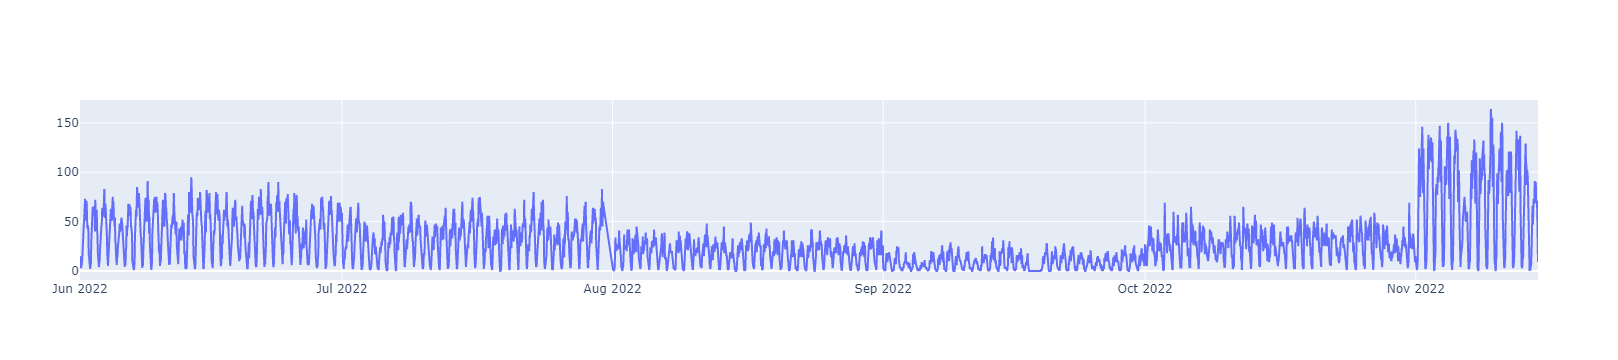

In [549]:
from plotly.offline import init_notebook_mode, iplot
iplot([{
    'x': train.iloc[:,:].index,
    'y': train.iloc[:,:][col],
    'name': col
}  for col in pd.DataFrame(train['demand']).columns])

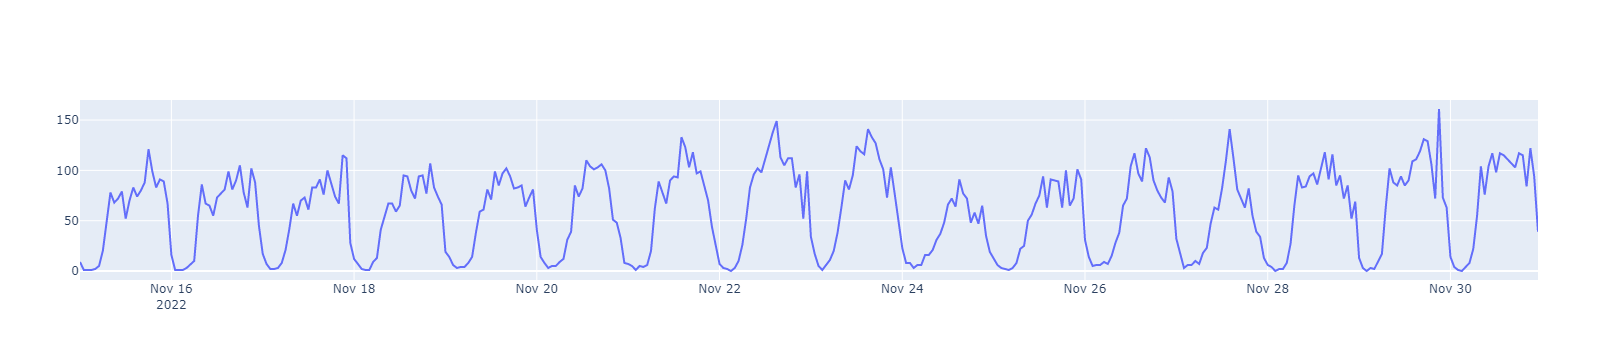

In [550]:
from plotly.offline import init_notebook_mode, iplot
iplot([{
    'x': test.iloc[:,:].index,
    'y': test.iloc[:,:][col],
    'name': col
}  for col in pd.DataFrame(test['demand']).columns])

## Time-Series Stationary or Not

### Augmented Dickey-Fuller (ADF) test
#### The null hypothesis of the ADF test is that the time series is non-stationary. A low p-value (typically less than 0.05) indicates that the null hypothesis can be rejected, meaning the time series is stationary. The ADF statistic can be compared to the critical values calculated from the test to determine whether it is stationary.

In [551]:
#Stationarity test
dftest = sts.adfuller(test.iloc[:,:].demand)
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.895153
p-value: 0.000036
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


### Kwiatkowski-Phillips-Schmidt-Shin test
#### The null hypothesis of the KPSS test is that the time series is stationary. If the test statistic is below a critical value, we fail to reject the null hypothesis and conclude that the time series is stationary. If the test statistic is above the critical value, we reject the null hypothesis and conclude that the time series is not stationary.

In [552]:
ts = np.cumsum(test.iloc[:,:].demand)

# Perform the KPSS test
kpss_stat, p_value, lags, crit = stattools.kpss(ts, regression='c')
print('KPSS test statistic:', kpss_stat)
print('p-value:', p_value)
print('Lags used:', lags)


KPSS test statistic: 3.303032983116173
p-value: 0.01
Lags used: 11


### Phillips-Perron (PP) test
#### If the p-value is less than a certain significance level, typically 0.05, we reject the null hypothesis that the series has a unit root and is non-stationary. If the p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that the series is non-stationary.

In [553]:
import statsmodels.api as sm

# Perform the test
result = sm.tsa.stattools.adfuller(test.iloc[:,:].demand, regression='c', autolag='AIC')
print('Test Statistic: ', result[0])
print('p-value: ', result[1])


Test Statistic:  -4.895152590446574
p-value:  3.564000825193033e-05


## ARIMAX

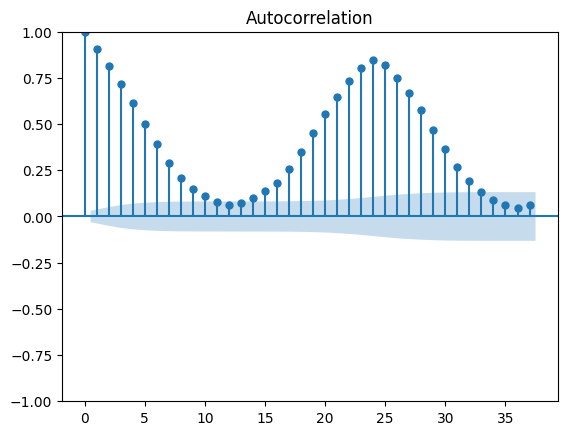

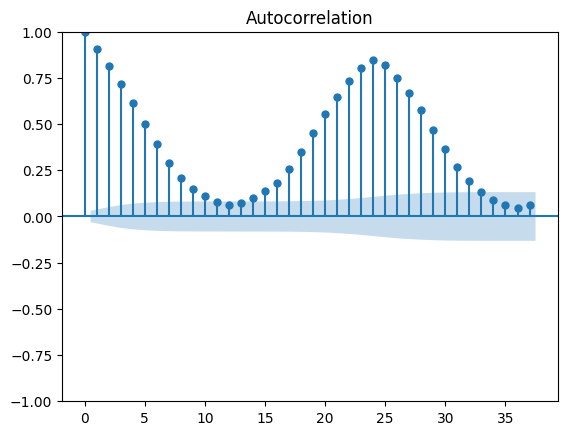

In [555]:
plot_acf(train.iloc[:,:].demand)

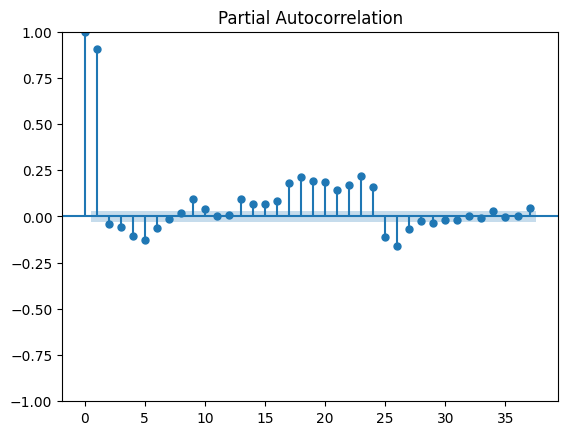

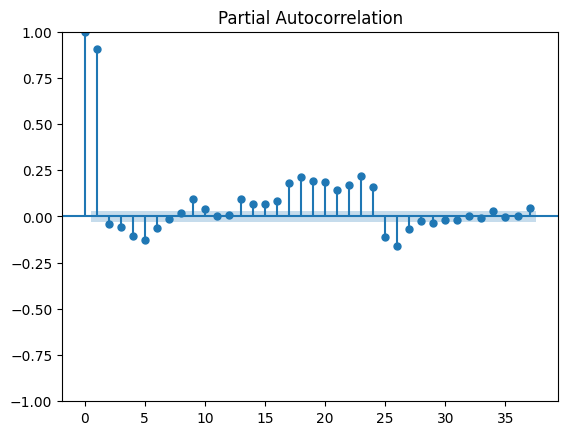

In [556]:
plot_pacf(train.iloc[:,:].demand)

In [557]:
# p_values = range(0,8)
# d_values = range(0,3)
# q_values = range(0,3)
# for p in p_values:
#     for d in d_values:
#         for q in q_values:
#             order = (p,d,q)
#             model = ARIMA(train.iloc[:,4:],order=order)
#             model_fit = model.fit()
#             forecast = model_fit.forecast(steps=1488)
#             mae = mean_absolute_error(test.iloc[:,4:], forecast)
#             print("order {}".format(order) ," Mean Absolute Error:{}".format(mae))

## SARIMAX

In [717]:
p_values = range(0,8)
d_values = range(0,3)
q_values = range(0,3)
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            model = SARIMAX(cluster_cleaned.iloc[:,:].demand, order=order, seasonal_order=(1, 1, 1, 12))
            results = model.fit()
            pred = results.get_prediction(start=pd.to_datetime("2022-11-16 00:00:00"), end=pd.to_datetime("2022-11-30 23:00:00"), dynamic=False)
            pred_conf = pred.conf_int()
            mae = (mean_absolute_error(cluster_cleaned.iloc[len(cluster_cleaned)-360:,:].demand,pred.predicted_mean))
            print("order {}".format(order) ," Mean Absolute Error:{}".format(mae))            

order (0, 0, 0)  Mean Absolute Error:15.857300998682453
order (0, 0, 1)  Mean Absolute Error:14.09788613213931
order (0, 0, 2)  Mean Absolute Error:13.887509702882
order (0, 1, 0)  Mean Absolute Error:14.216912285077898
order (0, 1, 1)  Mean Absolute Error:14.34477641514261
order (0, 1, 2)  Mean Absolute Error:14.334172164990807
order (0, 2, 0)  Mean Absolute Error:20.071883172677005
order (0, 2, 1)  Mean Absolute Error:14.21904431844914
order (0, 2, 2)  Mean Absolute Error:14.346736199411543
order (1, 0, 0)  Mean Absolute Error:13.70945267269299
order (1, 0, 1)  Mean Absolute Error:13.794968050467444
order (1, 0, 2)  Mean Absolute Error:13.801522612522414
order (1, 1, 0)  Mean Absolute Error:14.340227761540762
order (1, 1, 1)  Mean Absolute Error:13.80583078938652
order (1, 1, 2)  Mean Absolute Error:13.882904092075094
order (1, 2, 0)  Mean Absolute Error:17.57443161747437
order (1, 2, 1)  Mean Absolute Error:14.342376393959643
order (1, 2, 2)  Mean Absolute Error:14.276520745998319
o

13.06087039129284


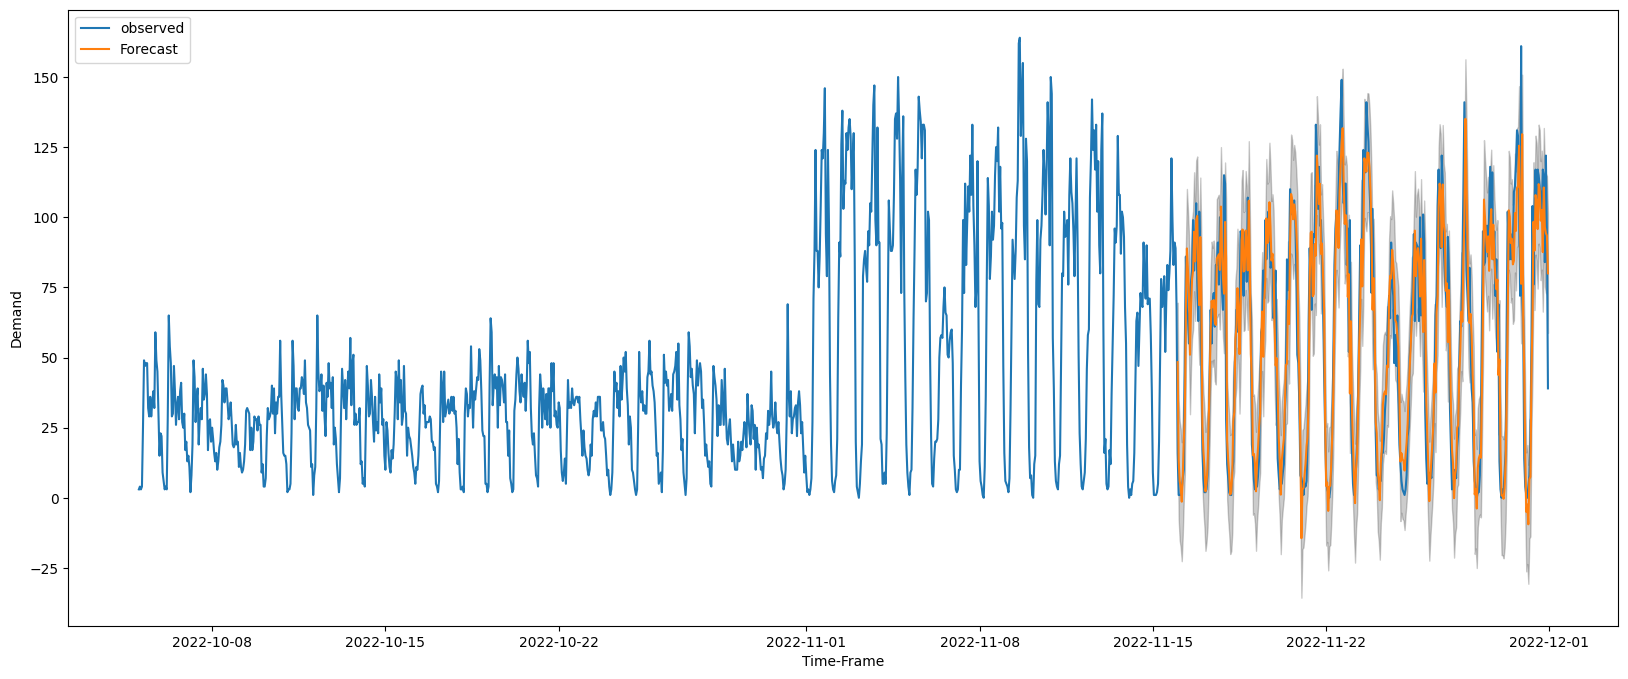

In [768]:
# fit SARIMAX model
model = SARIMAX(cluster_cleaned.iloc[:,:].demand, order=(5, 0, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()
# pred=results.predict(start=pd.to_datetime("2022-11-15"),end=pd.to_datetime("2022-11-30"),dynamic=True)
# df[['Sales','forecast']].plot(figsize=(12,8))
# make predictions
pred = results.get_prediction(start=pd.to_datetime("2022-11-16 00:00:00"), end=pd.to_datetime("2022-11-30 23:00:00"), dynamic=False)
pred_conf = pred.conf_int()

# plot actual vs predicted values
plt.figure(figsize=(20,8))
plt.plot(cluster_cleaned.iloc[3000:,:].demand, label='observed')
plt.plot(pred.predicted_mean, label='Forecast')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='k', alpha=.2)
plt.xlabel('Time-Frame')
plt.ylabel('Demand')
plt.legend()
plt.show()


In [769]:
print(mean_absolute_error(cluster_cleaned.iloc[len(cluster_cleaned)-360:,:].demand,pred.predicted_mean))

13.06087039129284


In [770]:
print(mean_squared_error(cluster_cleaned.iloc[len(cluster_cleaned)-360:,:].demand,pred.predicted_mean))

299.81293832847683


In [771]:
print(np.sqrt(mean_squared_error(cluster_cleaned.iloc[len(cluster_cleaned)-360:,:].demand,pred.predicted_mean)))

17.31510722832743
